In [1]:
import os
from dotenv import load_dotenv # requires python-dotenv

load_dotenv("./../credentials_my.env")
MODEL = os.environ["GPT4-1106-128k"]

In [2]:
from openai import AzureOpenAI

In [3]:
# Create the client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2024-02-15-preview", # at least 2024-02-15-preview is needed for 
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )

In [4]:
# Create an assistant
assistant = client.beta.assistants.create(
    name="Data Visualization",
    instructions=f"You are a helpful AI assistant who makes interesting visualizations based on data." 
    f"You have access to a sandboxed environment for writing and testing code."
    f"When you are asked to create a visualization you should follow these steps:"
    f"1. Write the code."
    f"2. Anytime you write new code display a preview of the code to show your work."
    f"3. Run the code to confirm that it runs."
    f"4. If the code is successful display the visualization."
    f"5. If the code is unsuccessful display the error message and try to revise the code and rerun going through the steps from above again.",
    tools = [{"type": "code_interpreter"}],
    model = MODEL
)

print(assistant.model_dump_json(indent=2))

{
  "id": "asst_N4EptBbRAMZ1anJzX9IqKrrY",
  "created_at": 1710836992,
  "description": null,
  "file_ids": [],
  "instructions": "You are a helpful AI assistant who makes interesting visualizations based on data.You have access to a sandboxed environment for writing and testing code.When you are asked to create a visualization you should follow these steps:1. Write the code.2. Anytime you write new code display a preview of the code to show your work.3. Run the code to confirm that it runs.4. If the code is successful display the visualization.5. If the code is unsuccessful display the error message and try to revise the code and rerun going through the steps from above again.",
  "metadata": {},
  "model": "gpt4-1106-128k",
  "name": "Data Visualization",
  "object": "assistant",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ]
}


In [5]:
# Create a thread
thread = client.beta.threads.create()
print(thread)

Thread(id='thread_1YooN5cVyBcNWEsYls64D65D', created_at=1710836993, metadata={}, object='thread')


In [6]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Create a visualization of a sinewave"
)

thread_messages = client.beta.threads.messages.list(thread.id)

print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_07TBieoU0QU0cOrT2miWcQ5D",
      "assistant_id": null,
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Create a visualization of a sinewave"
          },
          "type": "text"
        }
      ],
      "created_at": 1710836993,
      "file_ids": [],
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "status": null,
      "thread_id": "thread_1YooN5cVyBcNWEsYls64D65D"
    }
  ],
  "object": "list",
  "first_id": "msg_07TBieoU0QU0cOrT2miWcQ5D",
  "last_id": "msg_07TBieoU0QU0cOrT2miWcQ5D",
  "has_more": false
}


In [7]:
# Invoke the LLM, passing the whole thread message list

run            = client.beta.threads.runs.create(
  thread_id    = thread.id,
  assistant_id = assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

run.status

'queued'

In [8]:
# After the call completes, a new "assistant" message is appended to the thread
# The answer in the latest message may contain both text and image_file types

import time

start_time = time.time()
status = run.status

while status not in ["completed", "cancelled", "expired", "failed"]:
    run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
    print( f"Status: {status} after {int((time.time() - start_time) // 60)} minutes {int((time.time() - start_time) % 60)} seconds")
    time.sleep(5)
    status = run.status

print( f"\nStatus: {status} after {int((time.time() - start_time) // 60)} minutes {int((time.time() - start_time) % 60)} seconds")
messages = client.beta.threads.messages.list(thread_id=thread.id) 

print(f"\nHere are the messages of the thread <{thread.id}>:", messages.model_dump_json(indent=2), sep='\n')

Status: queued after 0 minutes 0 seconds
Status: queued after 0 minutes 5 seconds
Status: in_progress after 0 minutes 10 seconds
Status: in_progress after 0 minutes 15 seconds
Status: in_progress after 0 minutes 21 seconds
Status: in_progress after 0 minutes 26 seconds
Status: in_progress after 0 minutes 31 seconds
Status: in_progress after 0 minutes 37 seconds
Status: in_progress after 0 minutes 42 seconds
Status: in_progress after 0 minutes 47 seconds
Status: in_progress after 0 minutes 53 seconds
Status: in_progress after 0 minutes 58 seconds
Status: in_progress after 1 minutes 3 seconds
Status: in_progress after 1 minutes 8 seconds
Status: in_progress after 1 minutes 14 seconds
Status: in_progress after 1 minutes 19 seconds
Status: in_progress after 1 minutes 24 seconds
Status: in_progress after 1 minutes 30 seconds
Status: in_progress after 1 minutes 35 seconds

Status: completed after 1 minutes 40 seconds

Here are the messages of the thread <thread_1YooN5cVyBcNWEsYls64D65D>:
{
 

In [9]:
# If an "image_file" type is returned, retrieve the file id

import json

data = json.loads(messages.model_dump_json(indent=2))  # Load JSON data into a Python object
image_file_id = data['data'][0]['content'][0]['image_file']['file_id']

print(f"image_file_id: {image_file_id}")  # Outputs: assistant-1YGVTvNzc2JXajI5JU9F0HMD

image_file_id: assistant-F6AH9zigNGPOajo0wzLUPZnF


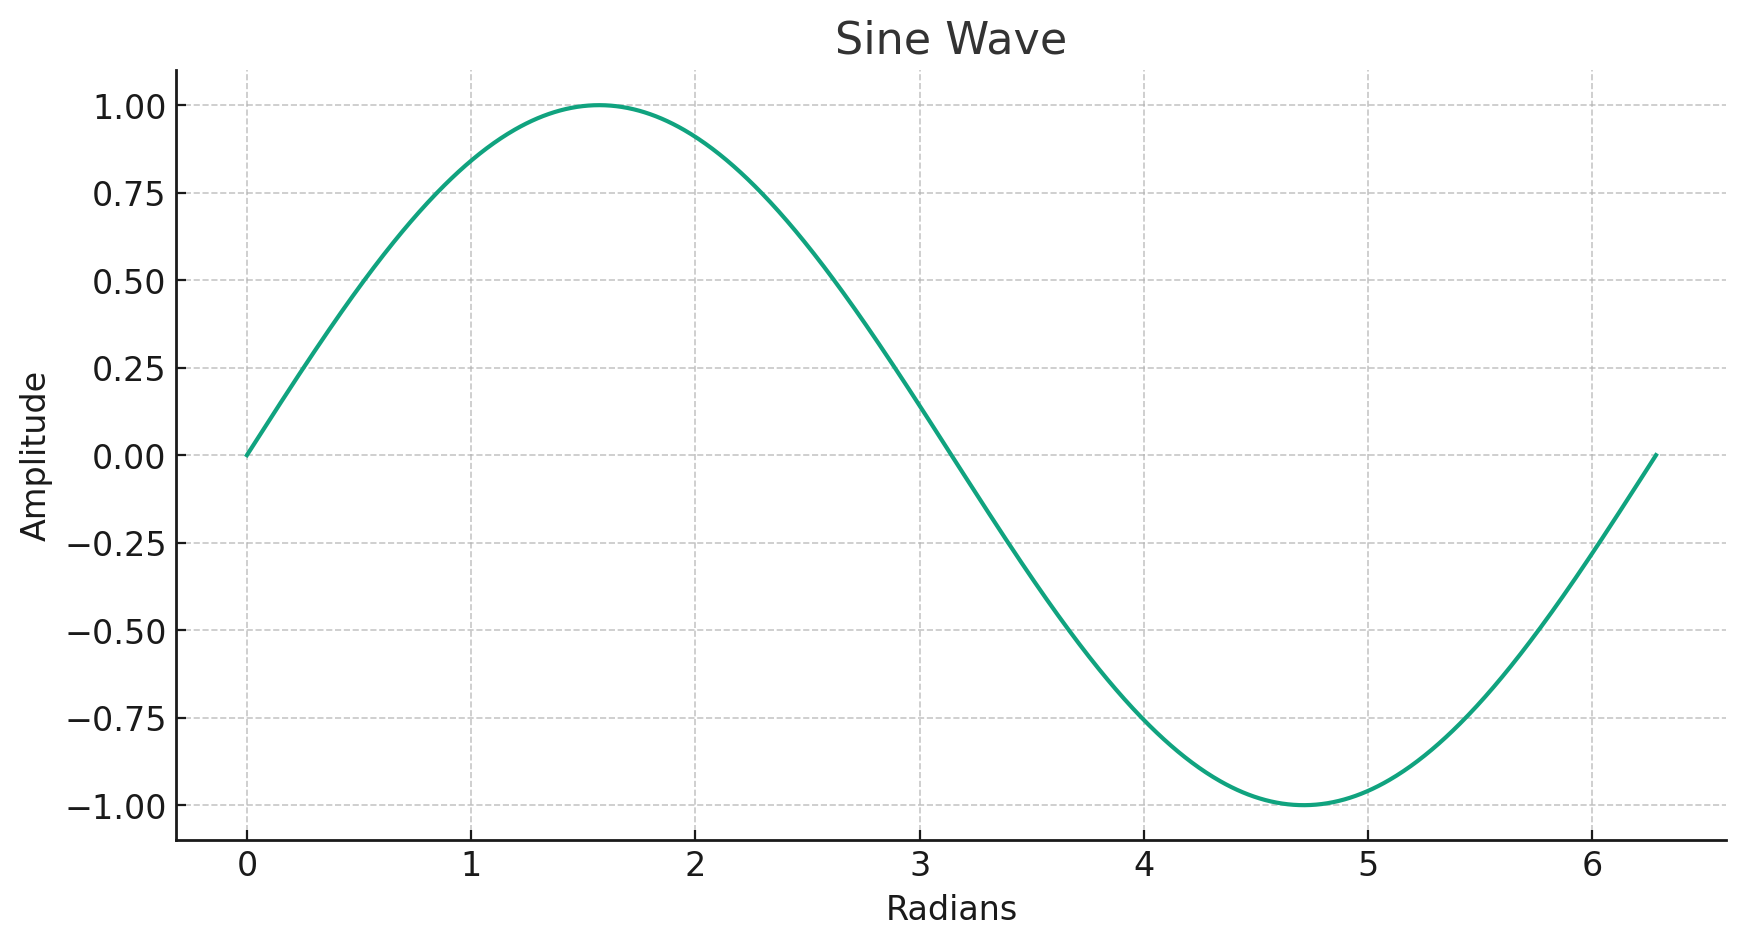

In [10]:
# Use the file id to retrieve the file content and save it on disk

from IPython.display import Image, display  
content = client.files.content(image_file_id)
image= content.write_to_file("sinewave.png")

# Display the image in the default image viewer
display(Image(filename='sinewave.png'))  

In [11]:
# Add a new user question to the thread, which is added to the thread messages list

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Show me the code you used to generate the sinewave"
)

In [12]:
# Same process as before: invoke the model passing the thread
# This time, the final assistant message contains only the text type, with the Python code as required

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

status = run.status

start_time = time.time()

while status not in ["completed", "cancelled", "expired", "failed"]:
    run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
    # clear_output(wait=True)
    print( f"Status: {status} after {int((time.time() - start_time) // 60)} minutes {int((time.time() - start_time) % 60)} seconds")
    time.sleep(5)
    status = run.status
    
messages = client.beta.threads.messages.list(thread_id=thread.id)

print(messages.model_dump_json(indent=2))

Status: queued after 0 minutes 0 seconds
Status: queued after 0 minutes 5 seconds
Status: in_progress after 0 minutes 10 seconds
Status: in_progress after 0 minutes 16 seconds
Status: in_progress after 0 minutes 21 seconds
Status: in_progress after 0 minutes 26 seconds
Status: in_progress after 0 minutes 31 seconds
{
  "data": [
    {
      "id": "msg_UGDe47WEH7fCdio0qSgIB4d5",
      "assistant_id": "asst_N4EptBbRAMZ1anJzX9IqKrrY",
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Certainly, here's the code that was used to generate the sine wave visualization:\n\n```python\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Generate a sine wave\nx = np.linspace(0, 2 * np.pi, 1000)  # Create an array of values from 0 to 2π with 1000 points in between\ny = np.sin(x)  # Calculate the sine of these points\n\n# Plot the sine wave\nplt.figure(figsize=(10, 5))  # Set the size of the figure\nplt.plot(x, y)  

In [13]:
# print the latest answer

data = json.loads(messages.model_dump_json(indent=2))
code = data['data'][0]['content'][0]['text']['value']
print(code)

Certainly, here's the code that was used to generate the sine wave visualization:

```python
import numpy as np
import matplotlib.pyplot as plt

# Generate a sine wave
x = np.linspace(0, 2 * np.pi, 1000)  # Create an array of values from 0 to 2π with 1000 points in between
y = np.sin(x)  # Calculate the sine of these points

# Plot the sine wave
plt.figure(figsize=(10, 5))  # Set the size of the figure
plt.plot(x, y)  # Plot x vs. y
plt.title('Sine Wave')  # Set the title of the plot
plt.xlabel('Radians')  # Label the x-axis as "Radians"
plt.ylabel('Amplitude')  # Label the y-axis as "Amplitude"
plt.grid(True)  # Turn on the grid lines

# Display the plot
plt.show()  # Show the plot
```

This code uses the NumPy library to generate the values for the sine wave and Matplotlib to plot the graph.


Status: queued after 0 minutes 0 seconds
Status: queued after 0 minutes 5 seconds
Status: in_progress after 0 minutes 10 seconds
Status: in_progress after 0 minutes 16 seconds
Status: in_progress after 0 minutes 21 seconds
Status: in_progress after 0 minutes 26 seconds
Status: in_progress after 0 minutes 31 seconds
Status: in_progress after 0 minutes 37 seconds


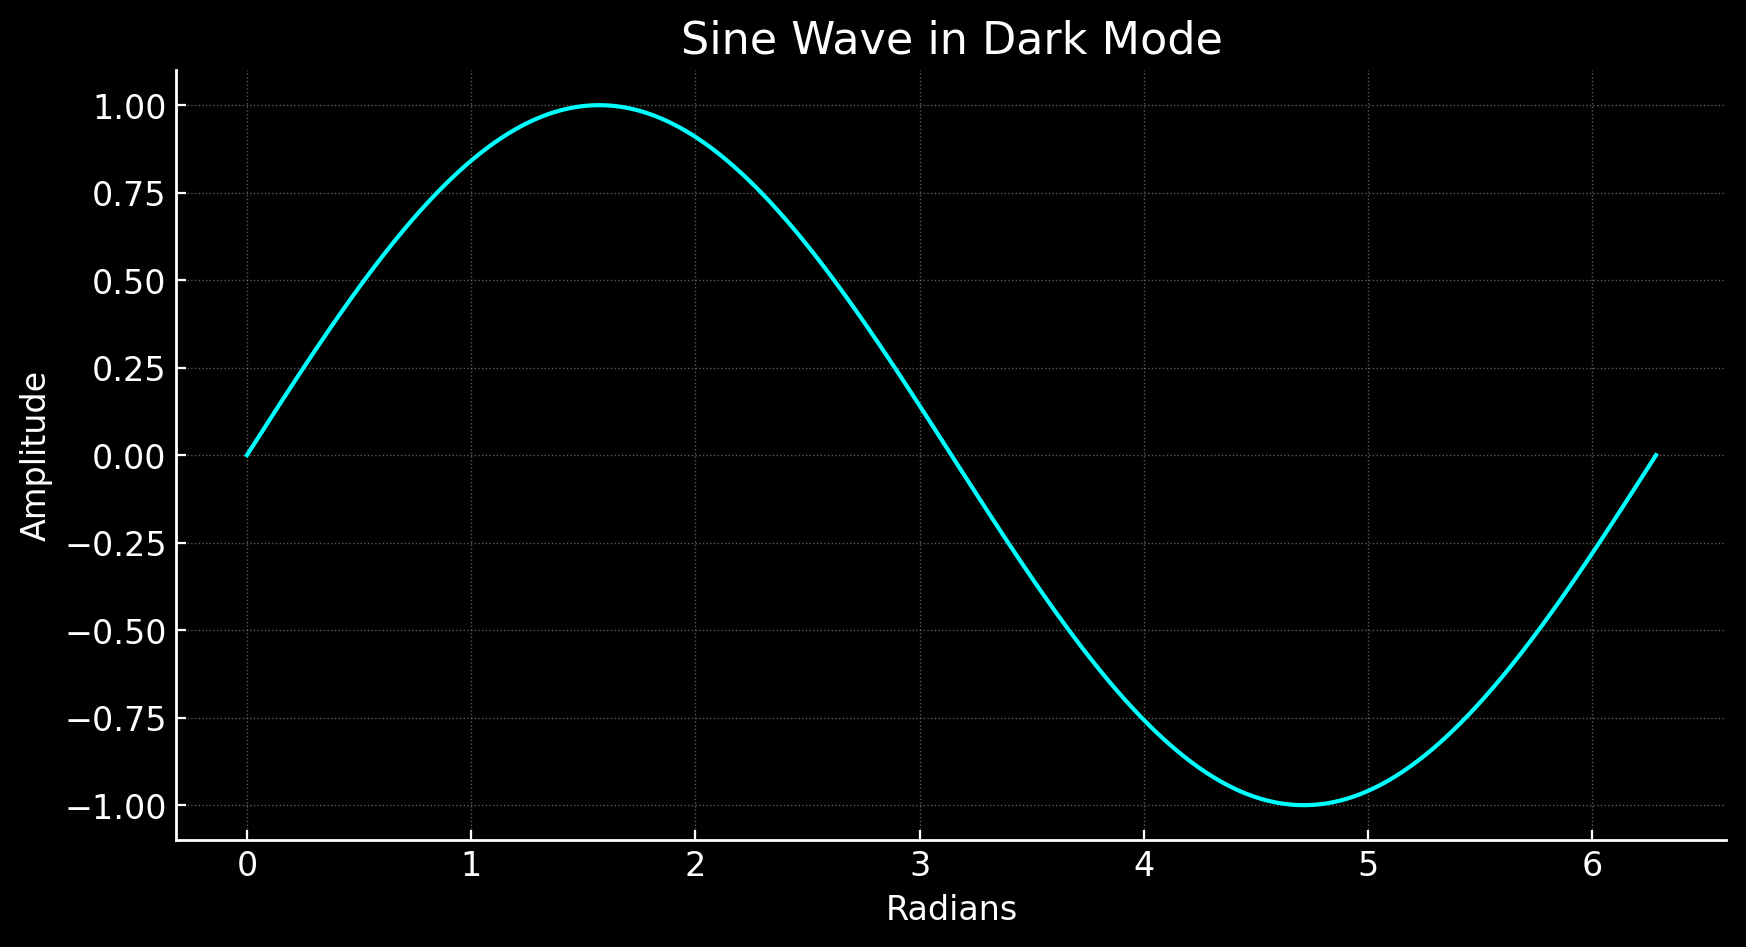

In [14]:
# New question: now we want the picture using dark mode
# Now we run everything in a single cell

# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="I prefer visualizations in darkmode can you change the colors to make a darkmode version of this visualization."
)

# Invoke the LLM passing the thread messages list
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  #instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

status = run.status
start_time = time.time()

# Wait until the answer is ready
while status not in ["completed", "cancelled", "expired", "failed"]:
    run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
    print( f"Status: {status} after {int((time.time() - start_time) // 60)} minutes {int((time.time() - start_time) % 60)} seconds")
    time.sleep(5)
    status = run.status
    

# Retrieve the thread messages list
messages = client.beta.threads.messages.list(thread_id=thread.id)

if run.status == "completed":
    data = json.loads(messages.model_dump_json(indent=2))  # Load JSON data into a Python object
    image_file_id = data['data'][0]['content'][0]['image_file']['file_id'] # index numbers can vary if you have had a different conversation over the course of the thread.

    content = client.files.content(image_file_id)
    image= content.write_to_file("dark_sine.png")

    # Display the image in the default image viewer
    display(Image(filename='dark_sine.png'))
else:
    print(f"error because of run.status: {run.status}")